In [1]:
import torch
import matplotlib as mpl
import os
%matplotlib widget
cmap = mpl.colormaps['viridis']
from tqdm.autonotebook import tqdm
from IPython.display import display
import h5py
import numpy as np
from torch.utils.data import DataLoader
from BasisConvolution.test_case_I.io import loadFile
from BasisConvolution.test_case_I.ablation import trainRBFNetwork
from BasisConvolution.test_case_I.dataset import loadTestcase
from BasisConvolution.test_case_I.eval import getTestingLossFrame
from BasisConvolution.test_case_I.train import trainModel
from BasisConvolution.test_case_I.util import getStackedUpdates, lossFunction, getGroundTruthKernel, getGroundTruthKernelGradient, getGroundTruthPhysics, getFeaturesKernel, getFeaturesPhysics
import pandas as pd

/tmp/ipykernel_20617/3874955913.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
trainingFiles = ['../../datasets/test_case_I/' + f for f in os.listdir('../../datasets/test_case_I/') if f.endswith('.hdf5')]

In [3]:
# Load generic settings
inFile = h5py.File(trainingFiles[0],'r')
minDomain = inFile.attrs['minDomain']
maxDomain = inFile.attrs['maxDomain']

baseArea = inFile.attrs['baseArea']
particleRadius = inFile.attrs['particleRadius']
particleSupport = inFile.attrs['particleSupport']

xsphConstant = inFile.attrs['xsphConstant']
diffusionAlpha = inFile.attrs['diffusionAlpha']
diffusionBeta = inFile.attrs['diffusionBeta']
kappa = inFile.attrs['kappa']
restDensity = inFile.attrs['restDensity']
c0 = inFile.attrs['c0']
dt = inFile.attrs['dt']

numParticles = inFile.attrs['numParticles']
timesteps = inFile.attrs['timesteps']

generator = inFile.attrs['generator']
inFile.close()

# Load generator settings
settings = {}
for f in trainingFiles:
    inFile = h5py.File(f,'r')
    generatorSettings = {}
    for k in inFile['generatorSettings'].attrs.keys():
        generatorSettings[k] = inFile['generatorSettings'].attrs[k]
#     print(generatorSettings)
    setup = {}
    setup['generatorSettings'] = generatorSettings
    setup['minDomain'] = inFile.attrs['minDomain']
    setup['maxDomain'] = inFile.attrs['maxDomain']

    setup['baseArea'] = inFile.attrs['baseArea']
    setup['particleRadius'] = inFile.attrs['particleRadius']
    setup['particleSupport'] = inFile.attrs['particleSupport']

    setup['xsphConstant'] = inFile.attrs['xsphConstant']
    setup['diffusionAlpha'] = inFile.attrs['diffusionAlpha']
    setup['diffusionBeta'] = inFile.attrs['diffusionBeta']
    setup['kappa'] = inFile.attrs['kappa']
    setup['restDensity'] = inFile.attrs['restDensity']
    setup['c0'] = inFile.attrs['c0']
    setup['dt'] = inFile.attrs['dt']

    setup['numParticles'] = inFile.attrs['numParticles']
    setup['timesteps'] = inFile.attrs['timesteps']

    setup['generator'] = inFile.attrs['generator']
    settings[f] = setup
    inFile.close()


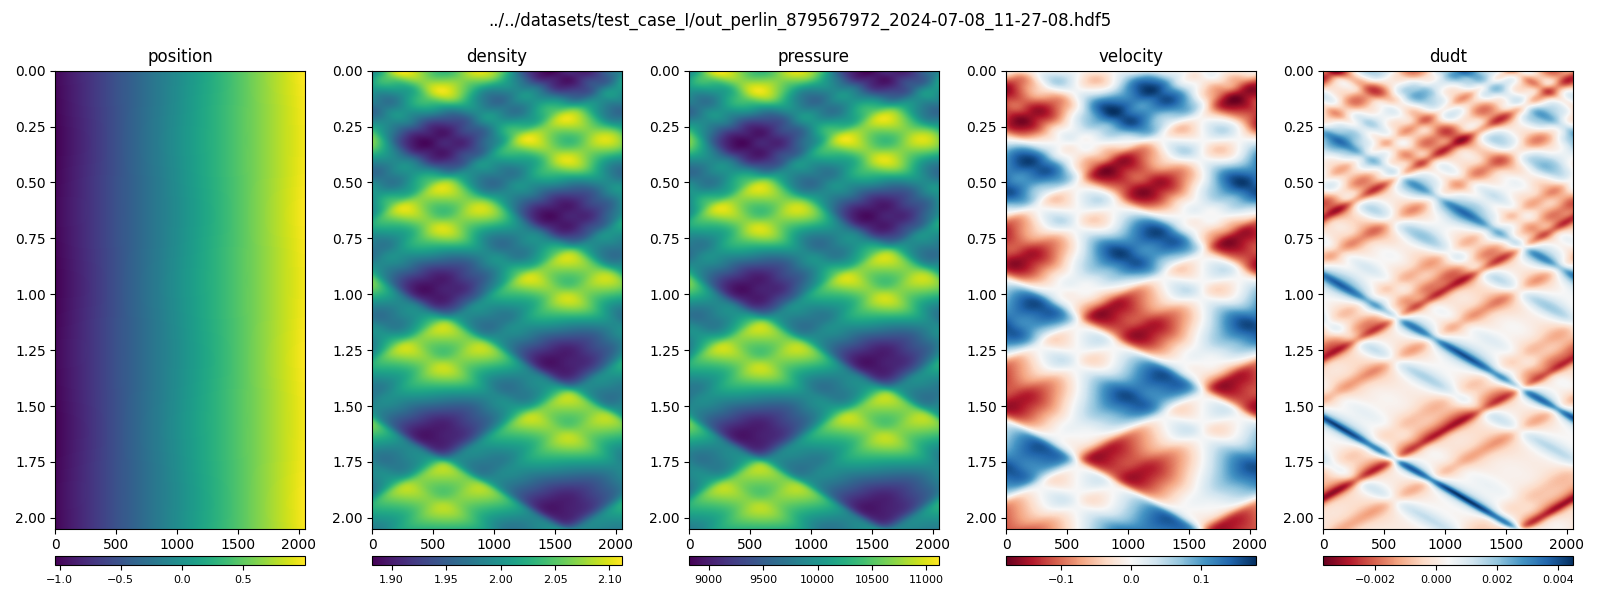

In [4]:
data = loadFile(trainingFiles[0], True)
# plotTrainingFiles(trainingFiles, numParticles, dt,  timesteps)

In [5]:
testingFiles = [f for f in trainingFiles if int(f.split('_')[4]) in [433611252, 960745502, 759352143, 37078787]]
trainingFiles = [f for f in trainingFiles if int(f.split('_')[4]) not in [433611252, 960745502, 759352143, 37078787]]
print(trainingFiles)

['../../datasets/test_case_I/out_perlin_879567972_2024-07-08_11-27-08.hdf5', '../../datasets/test_case_I/out_perlin_843734504_2024-07-08_11-27-36.hdf5', '../../datasets/test_case_I/out_perlin_549857803_2024-07-08_11-28-59.hdf5', '../../datasets/test_case_I/out_perlin_943800868_2024-07-08_11-26-42.hdf5', '../../datasets/test_case_I/out_perlin_141077155_2024-07-08_11-25-22.hdf5', '../../datasets/test_case_I/out_perlin_172735587_2024-07-08_11-28-30.hdf5', '../../datasets/test_case_I/out_perlin_09771992_2024-07-08_11-25-50.hdf5', '../../datasets/test_case_I/out_perlin_302569625_2024-07-08_11-28-03.hdf5', '../../datasets/test_case_I/out_perlin_521260098_2024-07-08_11-26-15.hdf5']


In [6]:
trainingData = {}
for f in tqdm(trainingFiles):
    trainingData[f] = loadFile(f, False)
testingData = {}
for f in tqdm(testingFiles):
    testingData[f] = loadFile(f, False)

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [7]:
offset = 16
for f in tqdm(trainingFiles):
    trainingData[f]['stacked'] = getStackedUpdates(trainingData[f]['positions'], trainingData[f]['velocity'], trainingData[f]['dudt'], offset - 1)
for f in tqdm(testingFiles):
    testingData[f]['stacked'] = getStackedUpdates(testingData[f]['positions'], testingData[f]['velocity'], testingData[f]['dudt'], offset - 1)

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [8]:
normalized = False # rbf normalization
batchSize = 4
maxUnrollsteps = 1
# offset = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
dataSet = []
for f in trainingFiles:
    nSteps = settings[f]['timesteps'] - maxUnrollsteps * (offset - 1)
    for j in range(offset - 1, nSteps):
        dataSet.append((f, j))
print('Dataset contains %d samples [%d files @ %d timesteps]' % (len(dataSet), len(trainingFiles), len(dataSet) / len(trainingFiles)))

Dataset contains 18162 samples [9 files @ 2018 timesteps]


In [9]:
torch.manual_seed('1337')


dataLoader = DataLoader(dataSet, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)
# Hyperparameters for the NN
lr = 1e-2 # Learning rate
iterations = 1000 # update iterations per epoch
epochs = 5 # total number of epochs, LR is halved every epoch

layers = [1]
initialLR = 1e-2
particleData = trainingData
# groundTruthFn = getGroundTruth
# featureFn = getFeatures
lossFn = lossFunction

inputFeatures = 1
seeds = np.random.randint(0, 2**30, 4)

In [10]:
next(dataIter)

[7793, 12337, 9234, 103]

In [11]:
testCase = 'kernel'

if testCase == 'kernel':
    groundTruthFn = getGroundTruthKernel
    featureFn = getFeaturesKernel
elif testCase == 'kernelGradient':
    groundTruthFn = getGroundTruthKernelGradient   
    featureFn = getFeaturesKernel 
elif testCase == 'physicsUpdate':
    groundTruthFn = getGroundTruthPhysics
    featureFn = getFeaturesPhysics
    
testData = {}
for i in range(len(testingFiles)):
#     testData[testingFiles[i].split('/')[-1].split('.')[0]] = loadTestcase(testingData, settings, testingFiles[i], [0, 128, 256, 1024], device, getGroundTruth, getFeatures, offset)
    testData['_'.join(testingFiles[i].split('/')[-1].split('.')[0].split('_')[1:3])] = loadTestcase(testingData, settings, testingFiles[i], [offset, 128, 256, 1024], device, groundTruthFn, featureFn, offset, particleSupport)

In [12]:
basis = 'rbf square'
window =  None
ns = [6]
widths = [1]
depths = [0]       
seeds = [0]
# runAblationStudyMLPOneLayer('PointNet', 'kernel', [32,32], widths, depths, messages, seeds, device, offset, particleSupport, trainingFiles, particleData, dataSet, testingFiles, testingData, settings)

In [13]:
# ns = [6]
# widths = [1,2,4,8,16,32]
# depths = [0,1,2,3,4,8,16]                
# for basis in tqdm(['fourier odd', 'dmcf', 'abf cubic_spline', 'fourier even', 'linear', 'ffourier', 'chebyshev', 'rbf square']):
#     for window in tqdm([None, 'poly6'], leave = False):
#         for testCase in tqdm(['physicsUpdate'], leave = False):          
#             trainRBFNetwork(basis, testCase, ns, widths, depths, window)

In [14]:
torch.nn.functional.relu


<function torch.nn.functional.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>

In [15]:
ns = [6]
widths = [1]
depths = [0]       
seeds = [1234567]
# for basis in tqdm(['fourier']):
#     for window in tqdm([None], leave = False):
#         for testCase in tqdm(['kernel'], leave = False):          
dataset = trainRBFNetwork('fourier', 'kernel', ns, widths, depths, seeds, None, device, particleSupport, trainingFiles, trainingData, dataSet, testingFiles, testingData, settings, offset)

display(dataset)
display(dataset['l2'].mean())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
testCase = 'kernel'
basis = 'fourier'


global testData
if testCase == 'kernel':
    groundTruthFn = getGroundTruthKernel
    featureFn = getFeaturesKernel
elif testCase == 'kernelGradient':
    groundTruthFn = getGroundTruthKernelGradient   
    featureFn = getFeaturesKernel 
elif testCase == 'physicsUpdate':
    groundTruthFn = getGroundTruthPhysics
    featureFn = getFeaturesPhysics

testData = {}
for i in range(len(testingFiles)):
    testData['_'.join(testingFiles[i].split('/')[-1].split('.')[0].split('_')[1:3])] = loadTestcase(testingData, settings, testingFiles[i], [offset, 128, 256, 1024], device, groundTruthFn, featureFn, offset, particleSupport)

layouts = []
for d in depths:
    for w in widths:
        l = [w] * d + [1]
        if l not in layouts:
            layouts.append(l)
dataset = pd.DataFrame()

#     for basis in tqdm(bases, leave = False):
dataset = pd.DataFrame()

trainedModel = trainModel(trainingData, testData, settings, dataSet, trainingFiles, fluidFeatures = 3 if testCase == 'physicsUpdate' else 1, offset = offset,
                  n = 8, basis = basis, layers = layouts[0], seed = 1337, particleSupport = particleSupport,
                 window = window, windowNorm = 'integral',
                 epochs = 5, iterations = 1000, initialLR = 1e-3, device = device, testInterval = 1000,
                 groundTruthFn = groundTruthFn, featureFn = featureFn, lossFn = lossFunction)
#         models.append(trainedModel)
trainedModel['model'].train(False)
df = getTestingLossFrame(trainedModel, testData, plot = False)
dataset = pd.concat([dataset, df])
#                 dataset.to_csv('ablationStudy_%s_%s window %s ns %s ws %s ds %s seeds %s.csv' % (testCase, basis, 'None' if window is None else window, '[' + ' '.join([str(d) for d in ns]) + ']', '[' + ' '.join([str(d) for d in widths]) + ']', '[' + ' '.join([str(d) for d in depths]) + ']', '[' + ' '.join([str(d) for d in seeds]) + ']'))



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

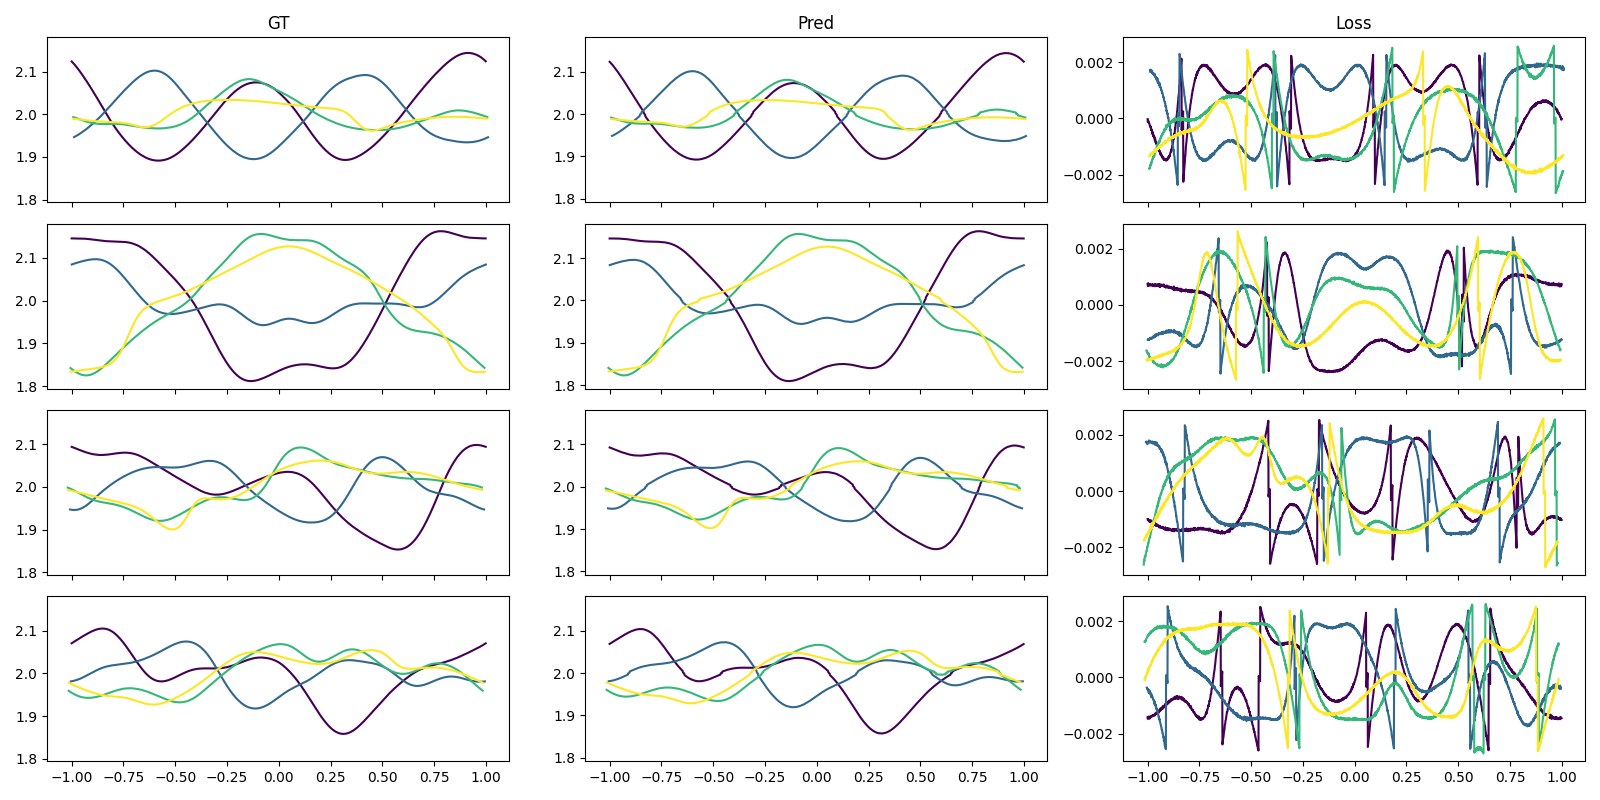

In [ ]:
df = getTestingLossFrame(trainedModel, testData, plot = True)